# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)
## Day 1B: Forward Simulations

- Here we build upon material learned in Day 1A  
- This notebook allows Users to play around with their own SPECFEM2D homogeneous halfspace example
- **Objective:** Familiarize Users with setting `SOURCE` and `STATION` attributes, adjusting velocity model parameters, and assess simulation results.
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0). 

-----------

**Relevant Links:** 
- Day 1 Slides !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb)
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


------
## 1) Set Up a SPECFEM Working Directory

- It is often desireable to run SPECFEM outside of the cloned repository, in order to keep files and outputs manageable  
- The trick here is that SPECFEM **only** requires 3 compenents for a sucessful simulation, the `bin/`, `DATA/`, and `OUTPUT_FILES/` directories  
- **NOTE:** We will working in the directory `/home/scoped/work/day_1/specfem2d_workdir`. All the following cells assume that we are in this directory  

In [1]:
# Python packages required for this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Create the correct dir. and move there
! mkdir -p /home/scoped/work/day_1/specfem2d_workdir
%cd /home/scoped/work/day_1/specfem2d_workdir

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_1/specfem2d_workdir
bin  DATA  OUTPUT_FILES


## 2) Experimental Setup: Tape et al. 2007 Example Problem

- We will be working with an Example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373)
- [GitHub repository location of the example problem](https://github.com/geodynamics/specfem2d/tree/devel/EXAMPLES/Tape2007)
- This example pre-defines two models (homogeneous halfspace, checkerboard), multiple (25) seismic sources, and multiple (132) stations  
- In this section we will use a homogeneous halfspace model  
- In your own research you can use any language to help you visualize and understand your problem, here we use Python  

In [3]:
! ls DATA/

interfaces_Tape2007.dat		  SOURCE_005  SOURCE_013  SOURCE_021
model_velocity.dat_checker	  SOURCE_006  SOURCE_014  SOURCE_022
Par_file_Tape2007_132rec_checker  SOURCE_007  SOURCE_015  SOURCE_023
Par_file_Tape2007_onerec	  SOURCE_008  SOURCE_016  SOURCE_024
SOURCE_001			  SOURCE_009  SOURCE_017  SOURCE_025
SOURCE_002			  SOURCE_010  SOURCE_018  STATIONS_checker
SOURCE_003			  SOURCE_011  SOURCE_019
SOURCE_004			  SOURCE_012  SOURCE_020


The above example problem defines:
- `Par_file` for a homogeneous halfspace model in `Par_file_Tape2007_onerec`
- `Par_file` for a checkerboard model in `Par_file_Tape2007_132rec_checker`
- `Mesh` files in: *interfaces_Tape2007.dat* and the `Par_file_*`
- `Model` files in: *model_velocity.dat_checker*
- `Source` files in: the 25 *SOURCE_???* files
- `Stations`: in the *STATIONS_checker* file

### a) The Homogeneous Halfspace Model

- The homogeneous halfspace model in this example is defined internally, in the `Par_file`
- A homogeneous halfspace defines single set of properties for the entire domain  
- You can find the velocity model in the `Par_file`
- Here we use the utility `seisflows sempar velocity_model` command to look at model values  

In [7]:
# Bash commands to look at the Par_file
! head -262 DATA/Par_file_Tape2007_onerec | tail -31
! echo "..."
# SeisFlows utility function to look at the Par_file
! seisflows sempar -P DATA/Par_file_Tape2007_onerec velocity_model

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 1
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

According to the `Par_file` comments, the model parameter values represent the following:  

```bash
model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0
1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
```

- The homogeneous halfspace model defines a region with P-wave velocity $V_p=5.8$km/s and S-wave velocity $V_s=3.5$km/s.
- The halfspace is also defined by density and attenuation
- We can understand the structure of the mesh by looking at the `Par_file` and the `interfaces_Tape2007.dat` file. 

In [8]:
# Look at Mesh parameters to view the size of the domain
! head -305 DATA/Par_file_Tape2007_onerec | tail -n 25

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = interfaces_Tape2007.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .true.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions                       = 1              # then set below the different regions and 

In [9]:
# Look at interface parameters 
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


#### Understanding the Mesh parameters

- From the files above, we can see that the X and Z dimensions of our mesh range from 0m to 480000.0m
- Each dimension is separated into 40 elements (defined by `nxmin`, `nxmax` etc. in the `Par_file` and defined by the layer numbers in the interfaces file)  
- That means each spectral element in our 2D mesh spans 12000.0m  (12km)
- Also note that above we previously learned that the $V_s$ model has a homogeneous value of 3.5 km/s

#### Visualizing the Model
We can make a simple plot using Matplotlib to illustrate what our mesh might look like

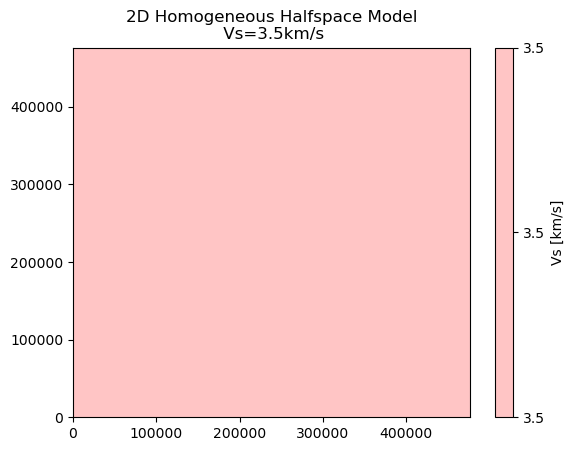

In [10]:
def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480000, 4000)
    z = np.arange(0, 480000, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

### b) Visualizing Source-Receiver Geometry

- We can similarly plot the SOURCES and STATIONS available to see what the experiemental setup looks like  
- This is the same Python-based approach we took in the Day 1A notebook

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

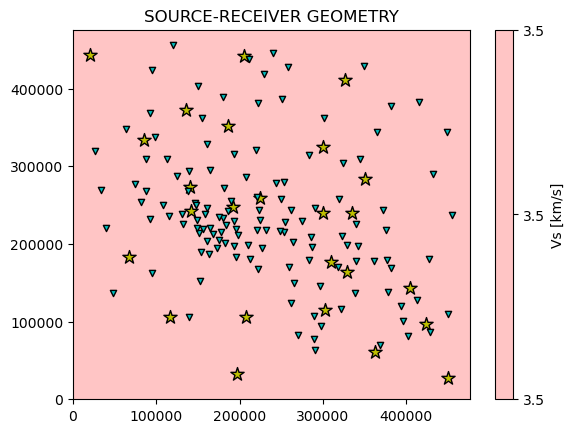

In [12]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

# Grab coordinates from each SOURCE file
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)
    
# Plot SOURCES and STATIONS together. Annotate names
plot_homogeneous_halfspace()
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES; N=25')

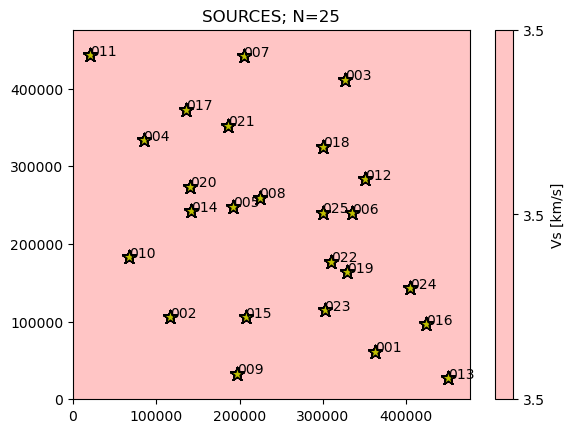

In [18]:
# Plot SOURCES next to source names
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
    plt.text(x, z, f"{i+1:0>3}")  # SOURCE numbering starts at 1
plt.title(f"SOURCES; N={len(ev_x)}")

Text(0.5, 1.0, 'STATIONS; N=132')

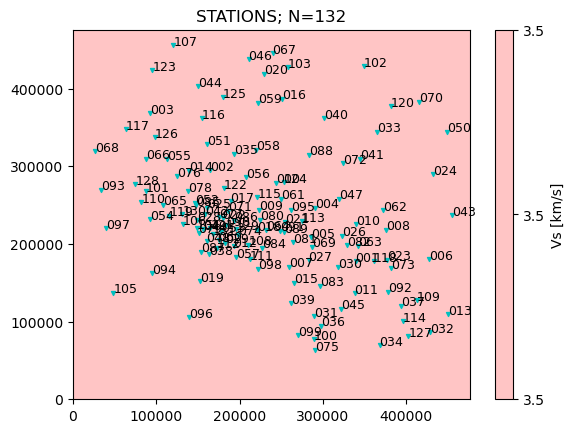

In [17]:
# Plot STATIONS with their names
# Because STATIONS are so close, numbers will be jumbled.
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=8)
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title(f"STATIONS; N={len(sta_x)}")

- Upside-down blue triangles represent the 132 receivers in this example
- The 25 yellow stars are the sources. 

----------
## 2) Running SPECFEM2D

- Before we run the example, we need to do some organizational bookkeeping  
- We will choose ONE of our source files to act as our source
- We will choose ONE stations to act as our station file  

### a) Choosing a Source file

- SPECFEM2D will look for a file named `SOURCE` in the *DATA/* directory to define its source

In [19]:
# Choose SOURCE_001 as our SOURCE File
! cp -f DATA/SOURCE_001 DATA/SOURCE

# > Make sure that the SOURCE name printed below matches choice
! head -1 DATA/SOURCE

## Source 1


### b) Choosing Stations

- SPECFEM2D will look for a file named `STATIONS` in the *DATA/* directory to define its stations
- The `STATIONS_checker` file defines 132 different station locations  
- We can choose what stations we use by copying over a subset of the original station list.
- We only want **one** of the 132 stations for this simulation  
- You can do this with Python, Bash, a text editor, etc.
- **NOTE**: Individual synthetic seismograms simply extract the simulated wavefield at a location, i.e., computational expense is not tied to the number of stations. 

In [21]:
# Write out a NEW stations file by choosing station numbers
! head -1 DATA/STATIONS_checker > DATA/STATIONS

In [22]:
! cat DATA/STATIONS

S000000 AA 2.43610e+05 2.78904e+05 0.0 0.0


### c) Setting up the `Par_file`

- SPECFEM2D will look for a file called `Par_file` in the *DATA/* directory to set its parameters
- We will copy over the `Par_file_Tape2007_onerec` to define our parameter file  
- We need to change a few key parameters in the `Par_file` to run SPECFEM2D with desired behavior.  
- We use the `seisflows sempar` command to make the changes but this can be done with a text editor, Bash etc.

In [23]:
# Copy in the Example parameter file
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some necessary parameters for later in the Par_file
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

NPROC: 1 -> 4
use_existing_STATIONS: .false. -> .true.


#### Par_file parameter changes

`NPROC`: Sets the number of MPI processors to partition the mesh and run the simulation with. This MUST match the value following `-n` in the MPI call below.    
`use_existing_STATIONS`: Use the STATIONS file we created, as opposed to the `Par_file` definition of stations  

### d) Run the example

- Now that we have set the `Par_file`, the `SOURCE` and `STATIONS` file, we are able to run `xmeshfem2D` and `xspecfem2D` to run our forward simulation.
- We use 4 MPI processes to run this homogeneous halfspace simulation
- We expect only **one** synthetic seismogram to be output from this simulation  

In [24]:
# Ensures we're running with a clean OUTPUT directory
! rm -rf OUTPUT_FILES
! mkdir OUTPUT_FILES

! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem.txt
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

### e) Examine Output Files

- Confirm that we have created **one** displacement seismogram
- Look at the forward simulation figures to see if things make sense


In [26]:
! ls OUTPUT_FILES/
! echo
! ls OUTPUT_FILES/*.semd

AA.S000000.BXY.semd	    forward_image000003000.jpg
Database00000.bin	    forward_image000003200.jpg
Database00001.bin	    forward_image000003400.jpg
Database00002.bin	    forward_image000003600.jpg
Database00003.bin	    forward_image000003800.jpg
forward_image000000005.jpg  forward_image000004000.jpg
forward_image000000200.jpg  forward_image000004200.jpg
forward_image000000400.jpg  forward_image000004400.jpg
forward_image000000600.jpg  forward_image000004600.jpg
forward_image000000800.jpg  forward_image000004800.jpg
forward_image000001000.jpg  forward_image000005000.jpg
forward_image000001200.jpg  mesh_materials.vtk
forward_image000001400.jpg  mesh_partition_number.vtk
forward_image000001600.jpg  output_list_stations.txt
forward_image000001800.jpg  output_meshfem.txt
forward_image000002000.jpg  output_solver.txt
forward_image000002200.jpg  plot_points_per_wavelength_histogram.gnu
forward_image000002400.jpg  plot_source_time_function.txt
forward_image000002600.jpg  points_per_wavelength

[2022-09-29 19:50:29] - pysep - INFO: starting record section plotter
[2022-09-29 19:50:29] - pysep - INFO: Reading 1 synthetics from: OUTPUT_FILES/
[2022-09-29 19:50:29] - pysep - INFO: checking parameter acceptability
[2022-09-29 19:50:29] - pysep - INFO: getting source-receiver stats
[2022-09-29 19:50:29] - pysep - INFO: calculating source-receiver distance and (back)azimuths
[2022-09-29 19:50:29] - pysep - INFO: preprocessing 1 `st` waveforms
[2022-09-29 19:50:29] - pysep - INFO: no filtering applied
[2022-09-29 19:50:29] - pysep - INFO: determining sort order with parameter: distance
[2022-09-29 19:50:29] - pysep - INFO: determining if any stations/channels should be skipped
[2022-09-29 19:50:29] - pysep - INFO: criteria check will remove 0/1 traces
[2022-09-29 19:50:29] - pysep - INFO: determining y-axis positioning for sort: distance
[2022-09-29 19:50:29] - pysep - INFO: determining amplitude scaling with: normalize
[2022-09-29 19:50:29] - pysep - INFO: plotting record section f

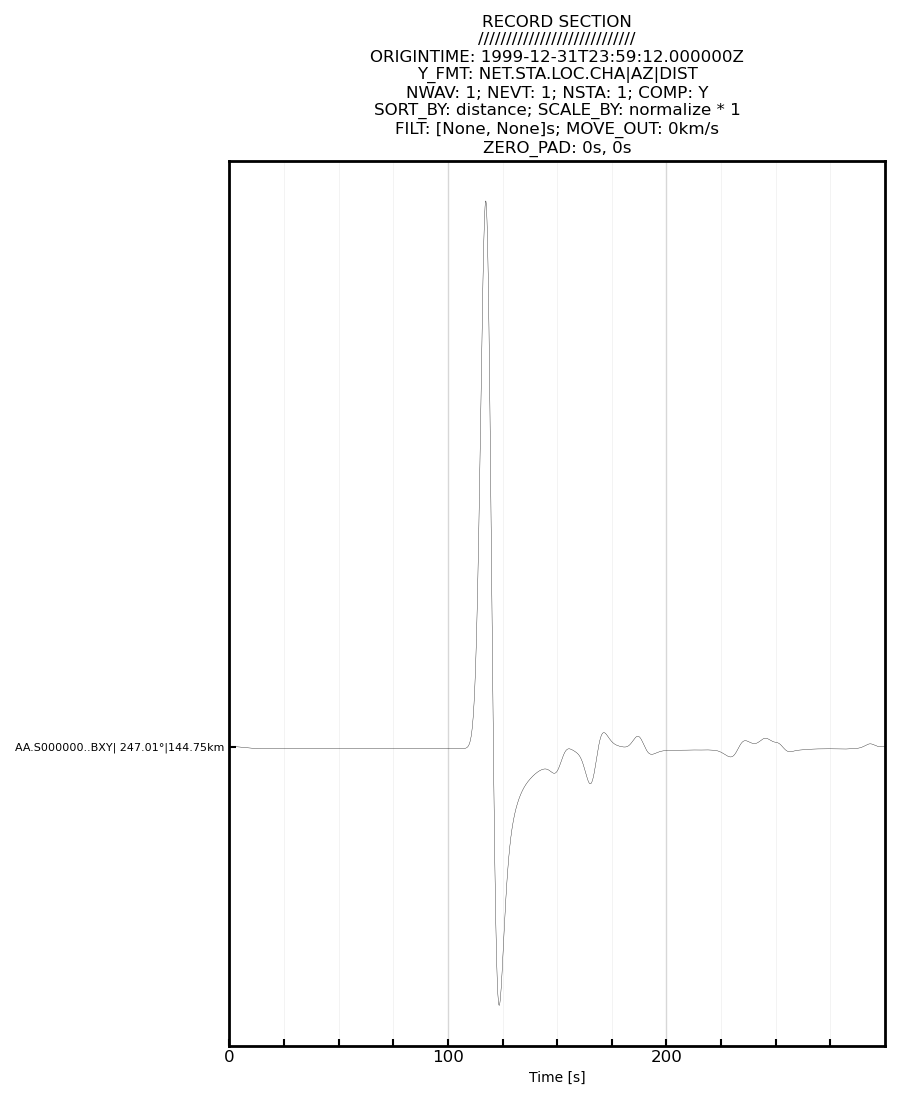

In [27]:
# We can use the record section tool in PySEP to plot our waveforms
! recsec --syn_path OUTPUT_FILES/ --cmtsolution DATA/SOURCE --stations DATA/STATIONS --components Y --cartesian -L INFO 
Image("record_section.png")

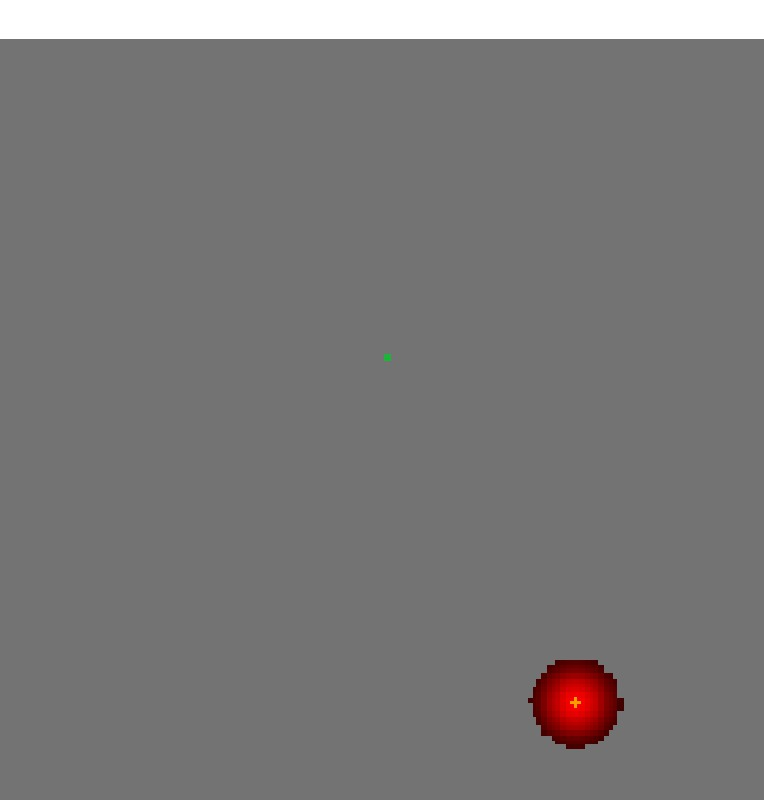

In [28]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000000800.jpg")

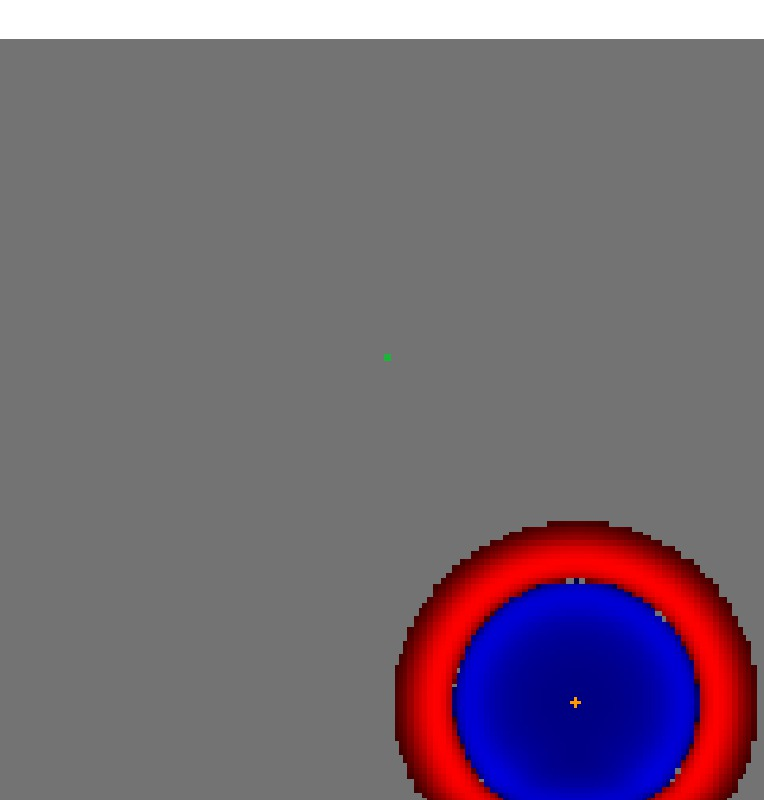

In [29]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000001200.jpg")

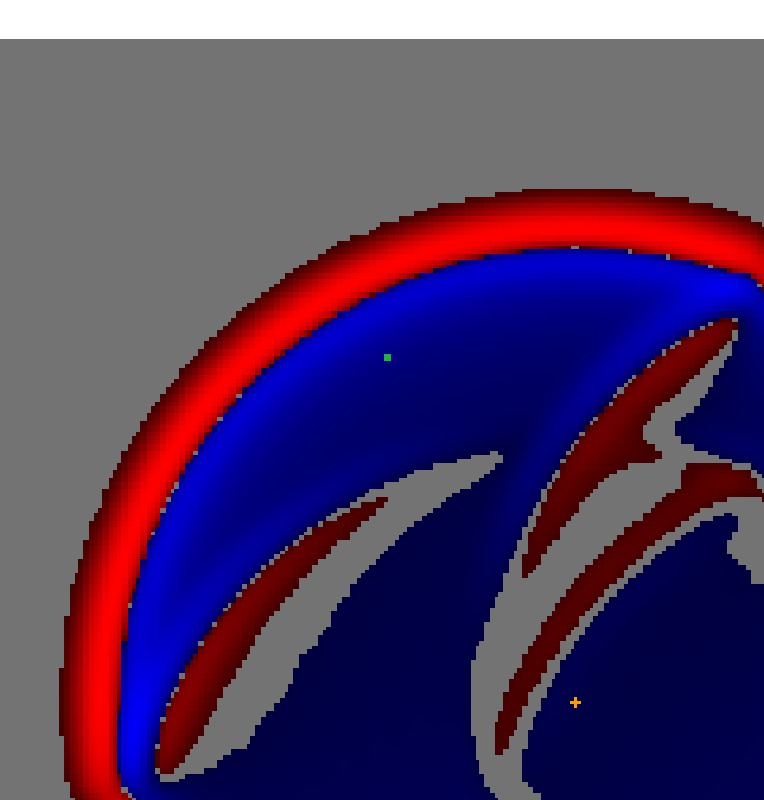

In [30]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000002200.jpg")

---------------------
## 3) Forward Simulation Exercise

- Participants will now be asked to edit simulation parameters to run their own unique simulation
- Some things that you are asked to try include:
    1) Change the parameters of the homogeneous halfspace model defined in the `Par_file` 
    2) Define a STATIONS file with a uniform grid of stations to record synthetics throughout the domain
    3) Choose a different source, or increase the energy released by the source (using the moment tensor)
    4) Re-run the mesher and solver to get new synthetics
    5) Analyze the new results in comparison to the old results

In [35]:
! rm -rf /home/scoped/work/day_1/exercise
! mkdir -p /home/scoped/work/day_1/exercise
%cd /home/scoped/work/day_1/exercise

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

# Set the Par_file
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file

! ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/home/scoped/work/day_1/exercise
bin  DATA  OUTPUT_FILES


#### Step 1: Edit the Velocity Model
- Change the velocity model parameters in the homogeneous halfspace model
- This model is defined in the `Par_file`
- Try **increasing** seismic velocity (Vp and Vs) by 10\%
- You can use Python, Bash, `seisflows sempar` or a Text Editor to do this  

In [31]:
# Figure out current values
! seisflows sempar -P DATA/Par_file velocity_model

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


In [32]:
vp = 5800. 
vs = 3500. * 1.1

print(f"vp={vp}; vs={vs}")

vp=6380.000000000001; vs=3850.0000000000005


In [33]:
# Overwrite the current velocity model with a +10% model
! seisflows sempar -P DATA/Par_file velocity_model "1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0"

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
->
1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


#### Step 2: Create a New STATIONS File
- Define a STATIONS file that covers the entier domain with a uniform grid spacing of dx=100km and dz=100km starting at (0, 0)
- Use Python/NumPy or simply write out a new text file with the text editor
- Look at *DATA/STATIONS_checker* for an example of how the file should look
- **NOTE**: The last two columns (burial, elevation) can be 0.

In [38]:
# Par_file defines the 'X' dimension of the mesh
! head -293 DATA/Par_file | tail -n 3

xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X


In [39]:
# Interfaces defines the 'Z' dimension of the mesh
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


In [66]:
# Loop through X and Z discretizations of 40km
i = 0
with open("DATA/STATIONS", "w") as f:
    for x in range(0, 480000, 100000):
        for z in range(0, 480000, 100000):
            f.write(f"S{i:0>6} AA {x:9.2f} {z:9.2f} 0. 0.\n")
            i += 1
            
! cat DATA/STATIONS

S000000 AA      0.00      0.00 0. 0.
S000001 AA      0.00 100000.00 0. 0.
S000002 AA      0.00 200000.00 0. 0.
S000003 AA      0.00 300000.00 0. 0.
S000004 AA      0.00 400000.00 0. 0.
S000005 AA 100000.00      0.00 0. 0.
S000006 AA 100000.00 100000.00 0. 0.
S000007 AA 100000.00 200000.00 0. 0.
S000008 AA 100000.00 300000.00 0. 0.
S000009 AA 100000.00 400000.00 0. 0.
S000010 AA 200000.00      0.00 0. 0.
S000011 AA 200000.00 100000.00 0. 0.
S000012 AA 200000.00 200000.00 0. 0.
S000013 AA 200000.00 300000.00 0. 0.
S000014 AA 200000.00 400000.00 0. 0.
S000015 AA 300000.00      0.00 0. 0.
S000016 AA 300000.00 100000.00 0. 0.
S000017 AA 300000.00 200000.00 0. 0.
S000018 AA 300000.00 300000.00 0. 0.
S000019 AA 300000.00 400000.00 0. 0.
S000020 AA 400000.00      0.00 0. 0.
S000021 AA 400000.00 100000.00 0. 0.
S000022 AA 400000.00 200000.00 0. 0.
S000023 AA 400000.00 300000.00 0. 0.
S000024 AA 400000.00 400000.00 0. 0.


#### Step 3: Choose and edit a SOURCE file

- Use `SOURCE_010` as your simulation source
- Change the moment tensor (Mxx, Mzz, Mxz) to make this an explosive source

In [58]:
! cp DATA/SOURCE_010 DATA/SOURCE
! head -51 DATA/SOURCE | tail -n 3

Mxx                             = 1.000000       # Mxx component (for a moment tensor source only)
Mzz                             = -1.000000      # Mzz component (for a moment tensor source only)
Mxz                             = 0.000000       # Mxz component (for a moment tensor source only)


In [59]:
lines = open("DATA/SOURCE", "r").readlines()
for i, line in enumerate(lines):
    for value in ["Mxx", "Mzz", "Mxz"]:
        if value in line:
            lines[i] = f"{value} = 1.0\n"

with open("DATA/SOURCE", "w") as f:
    f.writelines(lines)
    
! head -51 DATA/SOURCE | tail -n 3

Mxx = 1.0
Mzz = 1.0
Mxz = 1.0


#### Step 4: Run the Solver and Analyze Outputs

- Run the mesher and solver with your new experimental setup
- **Remember** to tell SPECFEM to use your `STATIONS` file and not its internal representation of stations
- **Remember** to tell SPECFEM that we want to run this with 4 processors
- Look at the source images to see if your explosion makes sense
- Plot waveforms output from your gridded stations

In [67]:
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

! tail OUTPUT_FILES/output_solver.txt

NPROC: 4 -> 4
use_existing_STATIONS: .true. -> .true.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 29 - 09 - 2022                                 T i m e  : 20:20:40
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


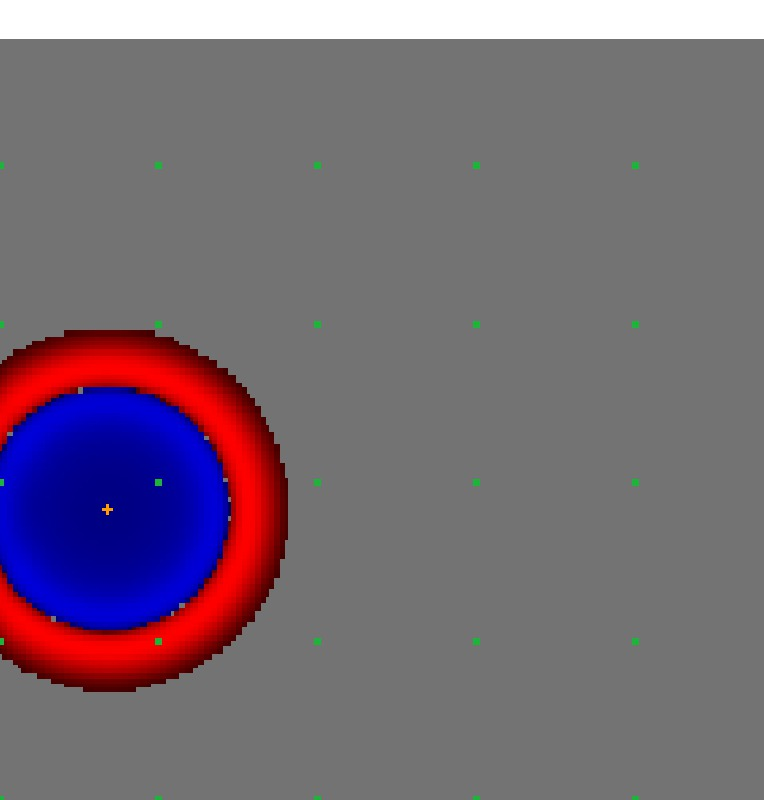

In [68]:
Image("OUTPUT_FILES/forward_image000001200.jpg")

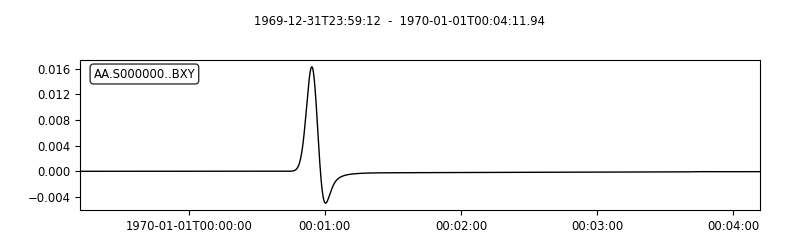

In [70]:
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --save AA.S000000.BXY.png
Image("AA.S000000.BXY.png")

-----------
## 4) Optional: Automating Forward Simulations with SeisFlows

- `SeisFlows` is an automated workflow tool which takes care of all the tasks required to run SPECFEM. 
- SeisFlows employs various preprocessing and optimization methods for seismic inversions (to be seen in Day 2 & 3). 
- We can automate forward simulations for multiple events in the Example we just ran. 
- SeisFlows Example \#3 runs a automated en-masse forward simulations.

In [ ]:
# Make sure were running in a clean working directory
! mkdir /home/scoped/work/day_1/sfexample_3
%cd /home/scoped/work/day_1/sfexample_3

# The `example` command will setup and run our forward simulations
! seisflows examples run 3 -r /home/scoped/specfem2d/ --with_mpi --nproc 2

#### Understanding SeisFlows outputs

- The example problem ran 10 simulations for 10 different sources (SOURCE_001 -> SOURCE_010)
- It used a homogeneous halfspace model, the same as shown above
- Each simulation output synthetic seismograms related to 25 station locations (Stations 1 -> 25)
- Each Solver directory is itself a small SPECFEM working directory
- SeisFlows stores its results in the `output/` directory
- In the example, we have told SeisFlows to export synthetic waveforms generated by the solver

In [ ]:
# Each Solver directory is a SPECFEM working directory
! ls scratch/solver
! echo
! ls scratch/solver/001

In [ ]:
# We ran through a homogeneous halfspace model !!! WRONG, FIX ME !!!
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

In [ ]:
# Each solver exported its synthetics to the output/ directory
! ls output/solver
! echo
!ls output/solver/001/syn

In [ ]:
# We can plot synthetics for a single station using RecSec
! recsec --syn_path "output/solver/001/syn" --cmtsolution 'specfem2d_workdir/DATA/SOURCE_001' --stations 'specfem2d_workdir/DATA/STATIONS' --components Y --cartesian --save "s01_recsec.png"
Image("s01_recsec.png")